In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from flask import Flask, jsonify

In [52]:
import numpy as np
import pandas as pd

In [53]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [55]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)
conn = engine.connect()

In [56]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [57]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [58]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [59]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [60]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurements.date).order_by(measurements.date.desc()).first()
print(last_date)
format_str = '%Y-%m-%d' # The format
last_date_obj = dt.datetime.strptime(last_date[0], format_str)

query_date = last_date_obj - dt.timedelta(days=365)
print(query_date)

# Perform a query to retrieve the data and precipitation scores

results = session.query(measurements.date, measurements.prcp)\
    .filter(measurements.date >= query_date)\
    .all()


# Save the query results as a Pandas DataFrame and set the index to the date column

results_df = pd.DataFrame(results, columns=['Date', 'precipitation'])


# Creates a new pandas datetime object variable
results_df['date_time']= pd.to_datetime(results_df['Date'], format='%Y-%m-%d')
results_df = results_df[['precipitation', 'date_time']]
results_df = results_df.set_index('date_time')
results_df.head()

('2017-08-23',)
2016-08-23 00:00:00


,precipitation
date_time,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


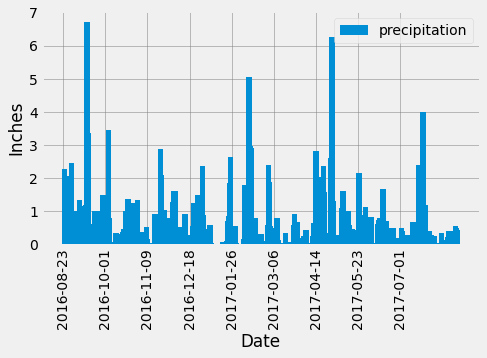

In [61]:
# # Use Pandas Plotting with Matplotlib to plot the data

tick_locations = [query_date]
for x in range(1, 9):
    tick_locations.append(query_date + dt.timedelta(days = 39*x))

tick_names = []
for x in tick_locations:
    tick_names.append(x.strftime('%Y-%m-%d'))
    
# print(tick_locations)
fig= plt.figure(figsize=(7,4)) 
plt.bar(results_df.index, results_df['precipitation'], width=5)
plt.xticks(tick_locations, tick_names , rotation="vertical")

    
# #Sets x and y ticks and labels to match pandas bar chart

plt.ylabel('Inches')
plt.xlabel('Date')
plt.grid(linestyle='-', linewidth='0.5', color='grey')
blue_patch = mpatches.Patch(label="precipitation")
plt.legend(handles=[blue_patch])
plt.show()

In [62]:
# Use Pandas to calculate the summary statistics for the precipitation data
results_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [63]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(stations.id)).all()

[(9)]

In [64]:
#confirms that all 9 stations in the stations table are represented in the measurements table
y= session.query(measurements.station).distinct()
station_list=[] 
for station in y:
        station_list.append(station)
station_list

[('USC00519397'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519523'),
 ('USC00519281'),
 ('USC00511918'),
 ('USC00516128')]

In [65]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurements.station, func.count(measurements.id)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
target_station = 'USC00519281'
sel = [
       func.max(measurements.tobs), 
       func.min(measurements.tobs), 
       func.avg(measurements.tobs)
]
session.query(*sel).\
        filter(measurements.station == target_station).all()

[(85.0, 54.0, 71.66378066378067)]

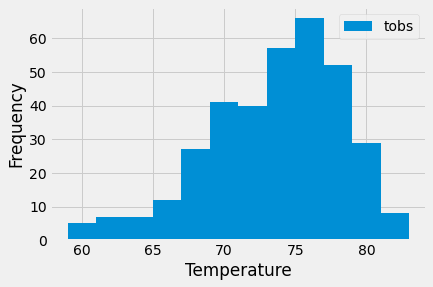

In [67]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result2 = session.query(measurements.tobs)\
    .filter(measurements.date >= query_date)\
    .filter(measurements.station == target_station)\
    .all()

result2 = list(np.ravel(result2))
plt.hist(result2, bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
blue_patch = mpatches.Patch(label="tobs")
plt.legend(handles=[blue_patch])
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
